### Function API

- Object Classification by Single Sigmoid activation
- Modify Anchor Assignment
  - Every Object should have at least 1 positive anchor
- Fix Focal loss alpha
  - For Recall boost, Weight to Maximum Positive anchor loss
  - fix alpha
- Modify Backbone : Resnet-34
  - Add Activation function
- Data Augmentation by split 2x2
- Data Augmentation by zoom in&out

#### Drawback

- Do not use data which not have any object
- Only 1 batch works
  - TFLite can't not use tf.shape() function, so can not separate batch data
  - if not use TFLite, multi batch ok

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [2]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.0', True)

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [147]:
padded_image_shape = (1024, 1920)
anchor_k = 9
num_classes = 80#
num_classes_real = 5
max_data_m = 5000
use_zoom_up_data = False
level_start = 3
level_end = 3+2
l1 = 1e-7
activation = 'relu'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
class_names = ['bg', '"water"', '"waterf"', '"land"', '"animal"']
#path_csv = '/home/sogangori/Downloads/water2/via_project_20200904_csv.csv'
path_csv = '/home/sogangori/Downloads/dataset/water/via_project_20200914.csv'
folder_water_image = folder_image = '/home/sogangori/Downloads/dataset/water/'
folder_weather = '/home/sogangori/Downloads/dataset/weather/'
path_weight = "retinanet/water"

os.path.isdir(folder_water_image), os.path.isfile(path_csv)

(True, True)

In [5]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect

True

In [6]:
img_paths = glob(folder_water_image + '*.*')
len(img_paths)

1294

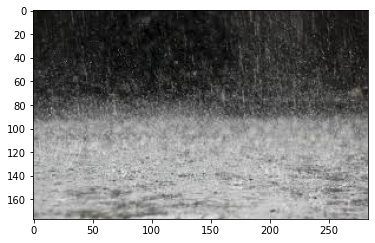

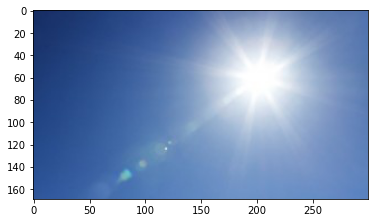

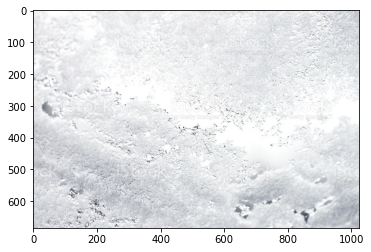

In [7]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()

In [8]:
df = pd.read_csv(path_csv)
df.shape

(3308, 7)

In [9]:
df.head()

filename  file_size file_attributes  region_count  region_id  \
0  00001.png    3697347              {}             5          0   
1  00001.png    3697347              {}             5          1   
2  00001.png    3697347              {}             5          2   
3  00001.png    3697347              {}             5          3   
4  00001.png    3697347              {}             5          4   

                             region_shape_attributes  \
0  {"name":"rect","x":1472,"y":735,"width":25,"he...   
1  {"name":"rect","x":1735,"y":627,"width":21,"he...   
2  {"name":"rect","x":1501,"y":461,"width":20,"he...   
3  {"name":"rect","x":1339,"y":407,"width":13,"he...   
4  {"name":"rect","x":1356,"y":408,"width":14,"he...   

            region_attributes  
0  {"object":{"waterf":true}}  
1   {"object":{"water":true}}  
2   {"object":{"water":true}}  
3   {"object":{"water":true}}  
4   {"object":{"water":true}}

In [10]:
df['filename'].nunique()

1355

In [11]:
annotation = dict()
for i in range(len(df)):
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
    box_map = ast.literal_eval(box)
         
    cls = 0
    for j in range(len(class_names)):        
        if class_names[j] in region_attributes:
            cls = j
            break
            
    #print(i, df.loc[i, 'filename'], box_map)
    if len(box_map.keys())<1:
        print(i, 'no_keys_skip', filename)
        continue
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
    x1 = x0 + width
    y1 = y0 + height
    if True:
        margin = 1
        #print('margin', width, margin)
        x0 -= margin
        y0 -= margin
        x1 += margin
        y1 += margin
    
    bbox = [cls, x0, y0, x1, y1]
    
    if region_id > 0:
        annotation[filename].extend(bbox)
    else:
        annotation[filename] = bbox
        
    #print(i, df.loc[i, 'filename'], width, height)

585 no_keys_skip 00222.png
622 no_keys_skip 00250.png
662 no_keys_skip 00283.png
663 no_keys_skip 00284.png
666 no_keys_skip 00287.png
835 no_keys_skip 00357.png
836 no_keys_skip 00358.png
837 no_keys_skip 00359.png
838 no_keys_skip 00360.png
869 no_keys_skip 00391.png
971 no_keys_skip 00434.png
1031 no_keys_skip 00460.png
1033 no_keys_skip 00462.png
1078 no_keys_skip 00473.png
1494 no_keys_skip 00578.png
2310 no_keys_skip 00752.png
2311 no_keys_skip 00753.png
2345 no_keys_skip 00778.png
2346 no_keys_skip 00779.png
2347 no_keys_skip 00780.png
2348 no_keys_skip 00781.png
2349 no_keys_skip 00782.png
2350 no_keys_skip 00783.png
2351 no_keys_skip 00784.png
2352 no_keys_skip 00785.png
2353 no_keys_skip 00786.png
2354 no_keys_skip 00787.png
2355 no_keys_skip 00788.png
2356 no_keys_skip 00789.png
2357 no_keys_skip 00790.png
2358 no_keys_skip 00791.png
2359 no_keys_skip 00792.png
2360 no_keys_skip 00793.png
2361 no_keys_skip 00794.png
2362 no_keys_skip 00795.png
2363 no_keys_skip 00796.png
236

In [12]:
input_list = []
bbox_list = []
for key in annotation:
    cls_bbox = annotation[key]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
        
    path_image = folder_image + key
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
    else:
        print('not exist', path_image)
    if len(input_list)>max_data_m:
        break

print(len(input_list), len(bbox_list))

1194 100 100
1194 200 200
1194 300 300
1194 400 400
1194 500 500
1194 600 600
1194 700 700
1194 800 800
1194 900 900
1194 1000 1000
1194 1100 1100
not exist /home/sogangori/Downloads/dataset/water/0108.png
not exist /home/sogangori/Downloads/dataset/water/0109.png
not exist /home/sogangori/Downloads/dataset/water/0110.png
not exist /home/sogangori/Downloads/dataset/water/0113.png
not exist /home/sogangori/Downloads/dataset/water/0129.png
not exist /home/sogangori/Downloads/dataset/water/0140.png
1188 1188


(3133, 5)


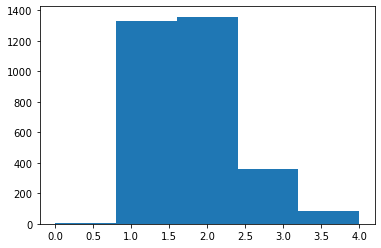

In [13]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0], bins=len(class_names))

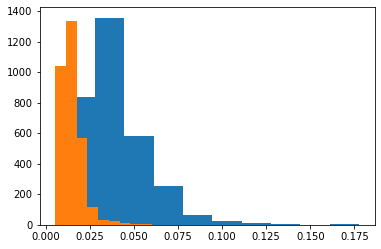

In [14]:
box_w = cbbox[:, -2] - cbbox[:, -4]
box_h = cbbox[:, -1] - cbbox[:, -3]
h = plt.hist(box_h)
h = plt.hist(box_w)

In [15]:
cbbox.shape

(3133, 5)

In [16]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [17]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [18]:
def tile_object(X, BBOX, scope=0.5):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            cy = np.mean((box_y_min + box_y_max)/2)
            cx = np.mean((box_x_min + box_x_max)/2)
            if cy < scope:
                ty0 = np.maximum(0, cy - scope/2)
                ty1 = ty0 + scope
            else:
                ty1 = np.minimum(1.0, cy + scope/2)
                ty0 = ty1 - scope
            if cx < 0.5:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            else:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
                        
            tbox = np.stack((cls, (x0 - tx0)/scope, (y0 - ty0)/scope, (x1 - tx0)/scope, (y1 - ty0)/scope), axis=1)
            img_y0 = int(ty0 * img_h)
            img_y1 = img_y0 + int(img_h*scope)
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[img_y0:img_y1, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            img_resized = img.resize((padded_image_shape[1]//2, padded_image_shape[0]//2 ))
            arr_resized = np.array(img_resized)            
            
            crop_xs.append(arr_resized)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [19]:
def attach_tiled_data(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        bg_color = np.median(X[i])
        attach_xs.append(bg_color + np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        cls, x0, y0, x1, y1 = np.split(bbox, 5, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((cls, x0, y0, x1, y1), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [20]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        box = bbox[:, 1:]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

In [21]:
def crop_obj(X, Y):
    crop_obj_list = []
    shape_list = []
    cls_list = []
    for i in range(len(X)):        
        x = X[i]        
        bboxs = Y[i]
        img_h, img_w, img_c = x.shape
        for j in range(len(bboxs)):
            box = bboxs[j]
            #print('box', box)
            cls, x0, y0, x1, y1 = list(box)
            x0 = int(x0 * img_w)
            x1 = int(x1 * img_w)            
            y0 = int(y0 * img_h)
            y1 = int(y1 * img_h)
            
            x_crop = x[y0:y1, x0:x1]
            if np.min(x_crop.shape)<3:
                continue
            crop_obj_list.append(x_crop)
            cls_list.append(cls)
            shape_list.append((x1-x0, y1-y0))
        
    return crop_obj_list, cls_list, shape_list

def attach_obj(crop_obj_list, cls_list, resize_w=32, resize_h=48):
    m = len(crop_obj_list)    
    img_h = padded_image_shape[0]
    img_w = padded_image_shape[1]
    row = img_h//resize_h
    col = img_w//resize_w
    img_m = (m - 1) // (row * col) + 1
    canvas = np.zeros((img_m, img_h, img_w, 3), dtype=np.uint8)
    cbbox_list = []
    for i in range(img_m):
        cbbox_list.append([])
    print('canvas', canvas.shape, row, col)
    cls_sort_index = np.argsort(cls_list)
    for j in range(m):
        i = cls_sort_index[j]
        x = crop_obj_list[i]
        cls = cls_list[i]
        #print(i, x.shape)
        arr = x.astype(np.uint8)
        img = Image.fromarray(arr)
        img = img.resize((resize_w, resize_h))
        x = np.array(img)
        tm = i // (row * col)
        ty = (i % (row * col) )// col
        tx = i % col
        #print(i, tm, ty, tx)
        x0 = tx*resize_w
        x1 = (tx+1)*resize_w
        y0 = ty*resize_h
        y1 = (ty+1)*resize_h
        canvas[tm, y0:y1, x0:x1] = x
        
        cbbox_list[tm].append(np.array([cls, 1.0*x0/img_w, 1.0*y0/img_h, 1.0*x1/img_w, 1.0*y1/img_h]))
        
    for i in range(img_m):
        cbboxs = cbbox_list[i]
        cbbox_list[i] = np.stack(cbboxs, axis=0)
    return canvas, cbbox_list


In [22]:
m = len(input_list)
print('m', m)
input_list = input_list[:m]
bbox_list = bbox_list[:m]
input_list_train = input_list[::2]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::2]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 1188
bbox_list_train 1188 594 594


img_objects, cls_list, shape_list = crop_obj(input_list_train, bbox_list_train)
print('len(img_objects)', len(img_objects), len(cls_list), img_objects[0].dtype)
print('shape_list', np.mean(np.stack(shape_list, 0), 0))

img_0 = rotate_images(img_objects, angle=1)
img_1 = rotate_images(img_objects, angle=-1)
img_2 = rotate_images(img_objects, angle=2)
img_3 = rotate_images(img_objects, angle=-2)
img_4 = rotate_images(img_objects, angle=3)
img_5 = rotate_images(img_objects, angle=-3)

img_objects = np.concatenate((img_objects, img_0, img_1, img_2, img_3, img_4, img_5), 0)
cls_list_original = cls_list.copy()
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
print(len(img_objects), len(cls_list))

attach_obj_img, attach_obj_bbox = attach_obj(img_objects, cls_list)
print('attach_obj_img', attach_obj_img.shape, len(attach_obj_bbox), len(attach_obj_bbox[0]))

display_data(attach_obj_img, attach_obj_bbox, stride=10)

attach_obj_img1, attach_obj_bbox1 = attach_obj(img_objects, cls_list, resize_w=28, resize_h=44)
print('attach_obj_img1', len(attach_obj_img1), len(attach_obj_bbox1[0]))
display_data(attach_obj_img1, attach_obj_bbox1, stride=5)

attach_obj_img2, attach_obj_bbox2 = attach_obj(img_objects, cls_list, resize_w=40, resize_h=58)
print('attach_obj_img2', len(attach_obj_img2), len(attach_obj_bbox2[0]))
display_data(attach_obj_img2, attach_obj_bbox2, stride=10)

attach_obj_img = np.concatenate((attach_obj_img, attach_obj_img1, attach_obj_img2), axis=0)
attach_obj_bbox.extend(attach_obj_bbox1)
attach_obj_bbox.extend(attach_obj_bbox2)
print('len', len(attach_obj_img), len(attach_obj_bbox))

plt.imshow(img_objects[0].astype(np.uint8))

In [27]:
crop_xs, crop_bboxs = tile_object(input_list_train, bbox_list_train)
print('crop_xs', len(crop_xs), len(crop_bboxs), crop_xs[0].shape, crop_bboxs[0])
#display_data(crop_xs, crop_bboxs, stride=100)

crop_xs 529 529 (512, 960, 3) [[2.         0.53229167 0.77222222 0.56041667 0.83518519]
 [1.         0.80625    0.57222222 0.83020833 0.65185185]
 [1.         0.5625     0.26481481 0.58541667 0.33518519]
 [1.         0.39375    0.16481481 0.409375   0.22222222]
 [1.         0.41145833 0.16666667 0.428125   0.21296296]]


In [24]:
rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=1.5)
rotate_xs_1, rotate_bboxs_1 = gen_rotate_data(crop_xs, crop_bboxs, angle=-1.5)

print('rotate_xs', len(rotate_xs), len(rotate_bboxs))
rotate_xs.extend(rotate_xs_1)
rotate_bboxs.extend(rotate_bboxs_1)

print('crop_xs', len(crop_xs), len(rotate_xs))

rotate_xs 529 529
crop_xs 529 1058


rotate_xs_2, rotate_bboxs_2 = gen_rotate_data(crop_xs, crop_bboxs, angle=2.5)
rotate_xs_3, rotate_bboxs_3 = gen_rotate_data(crop_xs, crop_bboxs, angle=-2.5)
rotate_xs.extend(rotate_xs_2)
rotate_bboxs.extend(rotate_bboxs_2)
rotate_xs.extend(rotate_xs_3)
rotate_bboxs.extend(rotate_bboxs_3)

In [25]:
print('crop_xs', len(crop_xs), len(rotate_xs))

crop_xs 529 1058


In [28]:
crop_xs.extend(rotate_xs)
crop_bboxs.extend(rotate_bboxs)

In [29]:
if use_weather_effect:
    weather_k = len(weather_images)
    print('weather_k', weather_k)
    m = len(crop_xs)
    for i in range(m):
        if np.random.rand() < 0.2:
            crop_x = crop_xs[i]
            h, w, c = crop_x.shape            
            weather_image = weather_images[np.random.randint(weather_k)]            
            crop_xs[i] = (crop_x // 3) * 2 + np.array(weather_image.resize((w, h)))//3

weather_k 3


In [30]:
attach_xs, attach_bboxs = attach_tiled_data(crop_xs, crop_bboxs, row=2, col=2)
print('attach_xs', len(attach_xs), len(attach_bboxs))

attach_xs 397 397


attach_xs33, attach_bboxs33 = attach_tiled_data(crop_xs, crop_bboxs, row=3, col=3)
attach_xs.extend(attach_xs33)
attach_bboxs.extend(attach_bboxs33)
print('attach_xs', len(attach_xs), len(attach_bboxs))

input_list_train = attach_xs
bbox_list_train = attach_bboxs

display_data(rotate_xs_, rotate_bboxs_, stride=10)

0 [1. 2. 3.]


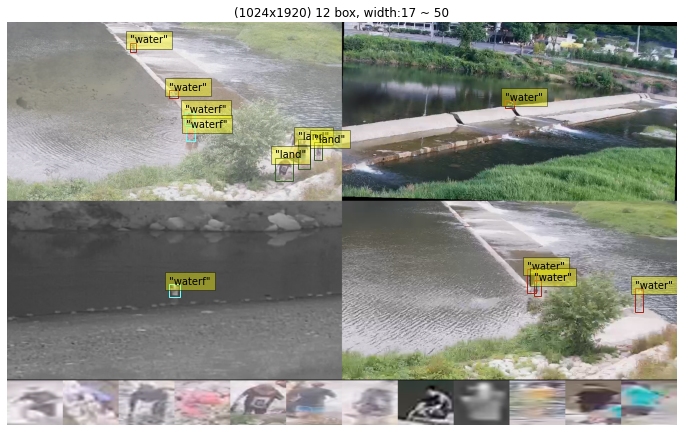

In [31]:
display_data(attach_xs, attach_bboxs, stride=500)

display_data(crop_xs, crop_bboxs, stride=10)

0 [1. 2.]


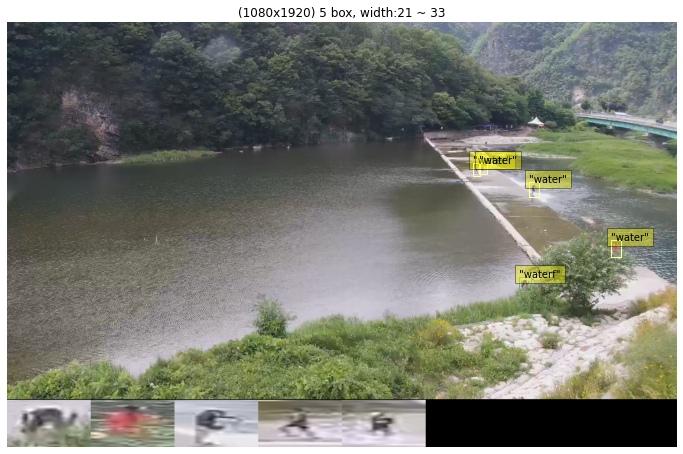

500 [1. 2.]


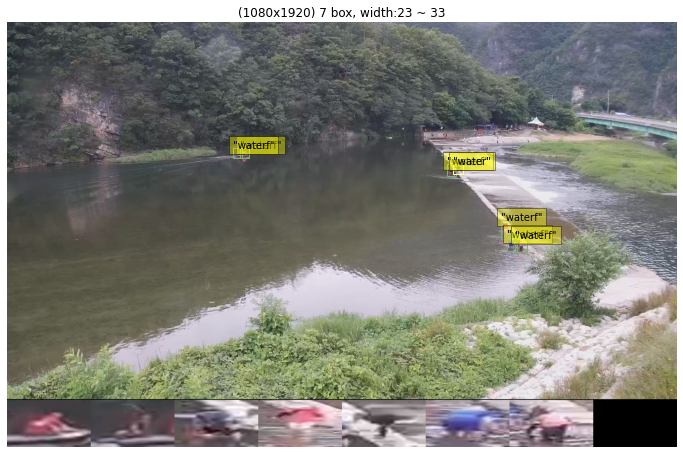

1000 [2.]


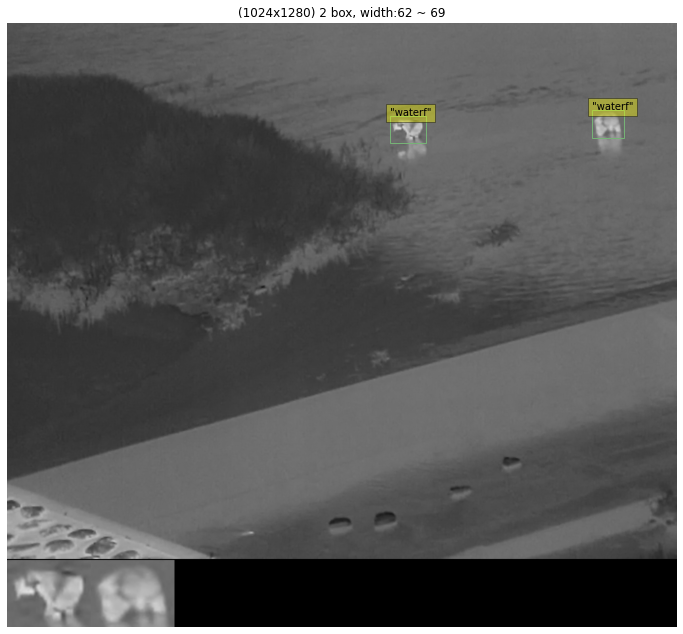

In [30]:
display_data(input_list, bbox_list, stride=500)

In [32]:
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 594 1587 397


In [33]:
use_zoom_up_data

False

In [34]:
stride = len(input_list_train) // len(attach_xs)
stride = max(1, stride)
for i in range(len(attach_xs)):
    input_list_train.insert(i*stride, attach_xs.pop())
    bbox_list_train.insert(i*stride, attach_bboxs.pop())
if use_zoom_up_data:
    for i in range(len(crop_xs)):
        input_list_train.insert(1+i*stride, crop_xs.pop())
        bbox_list_train.insert(1+i*stride, crop_bboxs.pop())
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 991 1587 0


stride = len(input_list_train) // len(attach_obj_img)
for i in range(len(attach_obj_img)):    
    input_list_train.insert(i*stride, attach_obj_img[i])
    bbox_list_train.insert(i*stride, attach_obj_bbox[i])

print('len', len(input_list_train), len(attach_obj_img))

input_list_train.extend(list_visdrone_image_arr)
input_list_test.extend(list_visdrone_image_arr)
bbox_list_train.extend(list_visdrone_cbbox)
bbox_list_test.extend(list_visdrone_cbbox)

In [35]:
print('len', len(input_list_train), len(input_list_test))

len 991 594


0 [1. 2.]


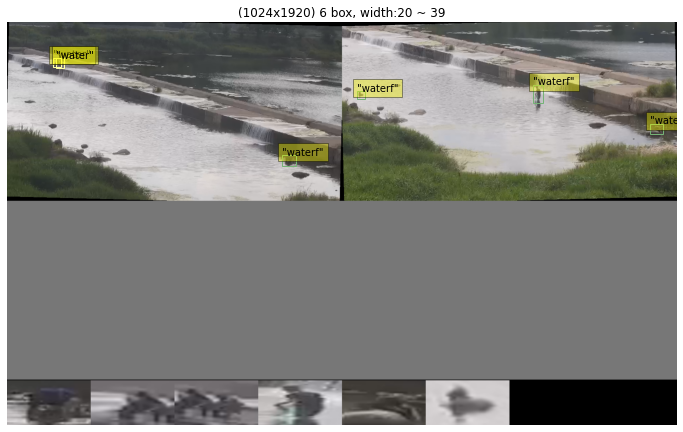

99 [1.]


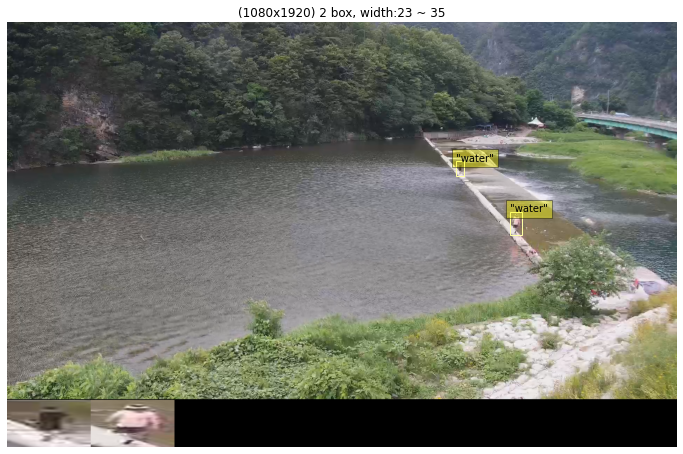

198 [1. 2. 3.]


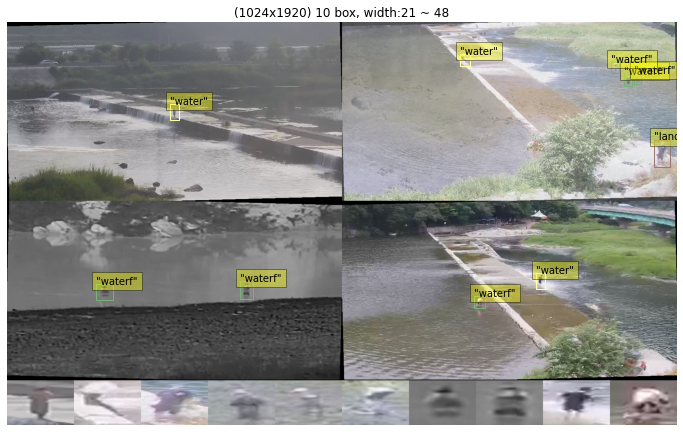

297 [1.]


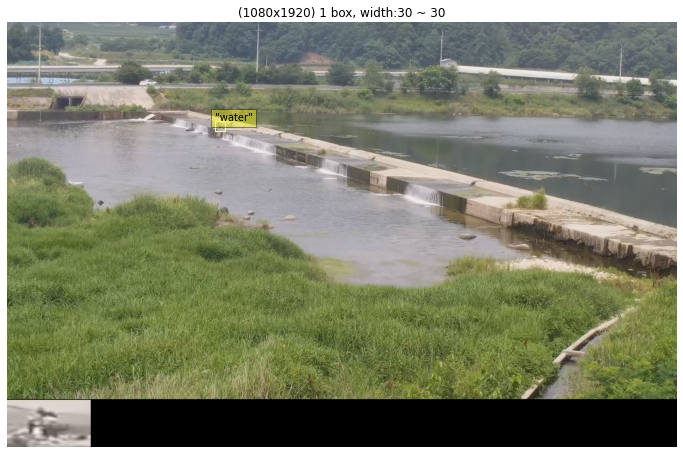

396 [1. 2. 3.]


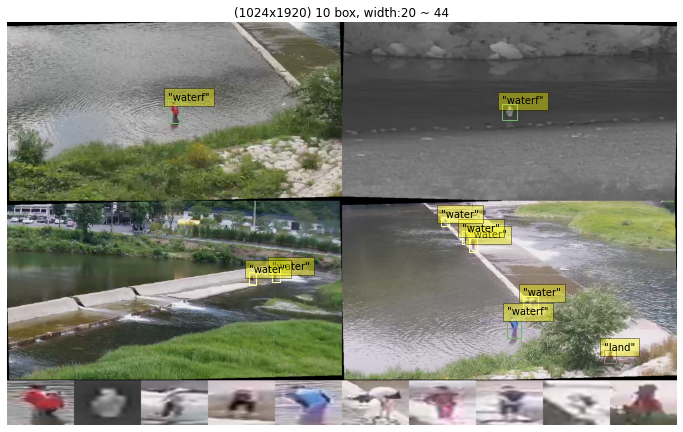

495 [2.]
crop_bbox_image 21 28 crop_image_arr.shape (28, 0, 3)


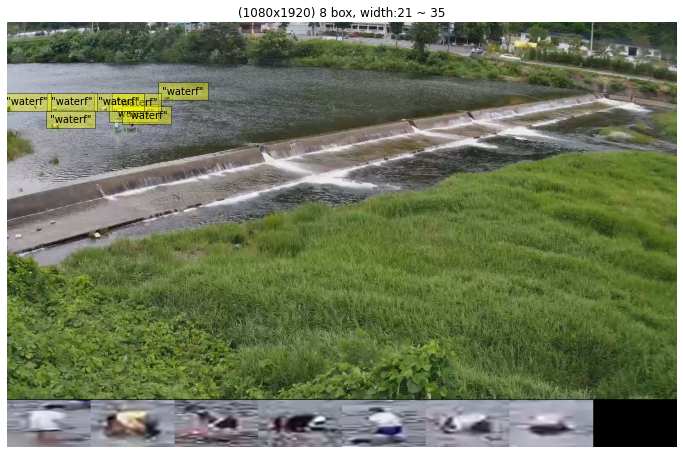

594 [3.]


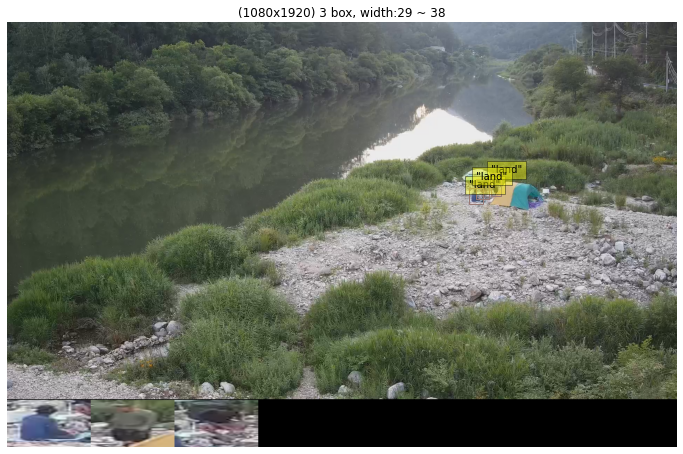

693 [1.]


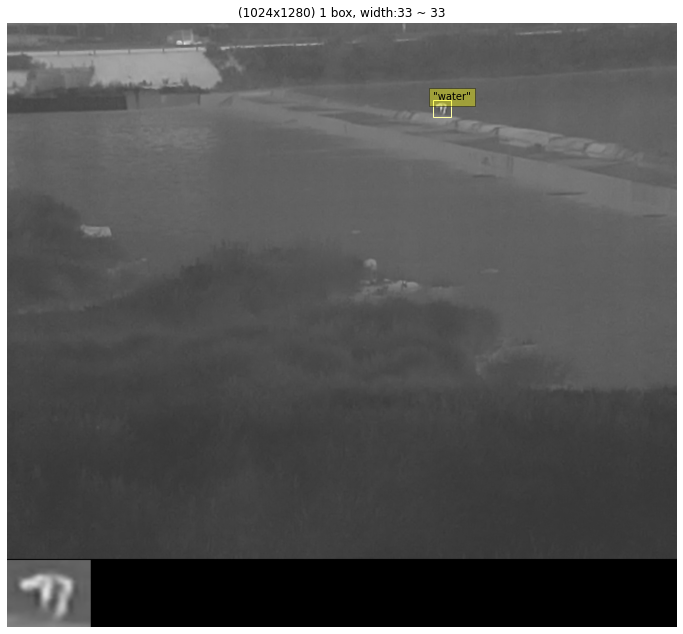

792 [2.]


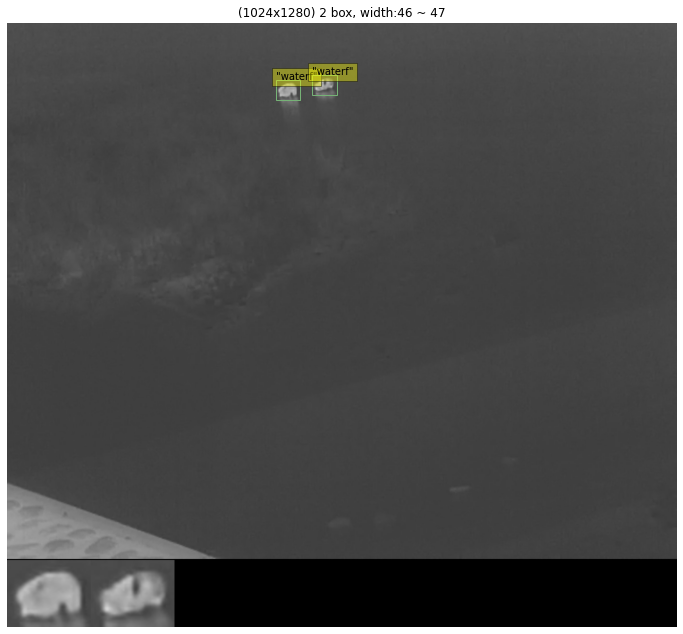

In [35]:
display_data(input_list_train, bbox_list_train, stride=99)

In [23]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [24]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [25]:
level_start, level_end

(3, 5)

In [26]:
anchor_check = AnchorBox()

In [27]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(2304, 4) tf.Tensor([124.       124.        71.83757   35.918785], shape=(4,), dtype=float32)
(576, 4) tf.Tensor([120.      120.      143.67514  71.83757], shape=(4,), dtype=float32)


In [308]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
        
    return image, boxes

def random_flip_vertical(image, boxes):
    is_flipped = tf.zeros_like(boxes[:, 0])
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        boxes = tf.stack([boxes[:, 0], 1 - boxes[:, 3], boxes[:, 2], 1 - boxes[:, 1]], axis=-1)
        is_flipped = tf.ones_like(is_flipped)
        
    return image, boxes, is_flipped

def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    
    #padded_image_shape = tf.cast(tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    ) 
    
    return image, image_shape, ratio

def resize_and_pad_image_bbox(
    image, bbox, min_side=1024.0, max_side=1024.0*4, jitter=[128*7-32, 128*9+32], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -64, 64, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    return image, padded_image_shape, ratio, bbox_padded


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    is_flipped = tf.zeros_like(class_id)
    #image, bbox, is_flipped = random_flip_vertical(image, bbox)    
    
    is_flipped = tf.cast(is_flipped, tf.int32)
    
    image, image_shape, _ = resize_and_pad_image(image)
    #image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)
    
    margin = 0#new
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1] + margin,
            bbox[:, 1] * image_shape[0] + margin,
            bbox[:, 2] * image_shape[1] - margin,
            bbox[:, 3] * image_shape[0] - margin,
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


def preprocess_test_data(image, cls_bbox):         
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)        
    
    image, image_shape, _ = resize_and_pad_image(image)
    
    is_flipped = tf.zeros_like(class_id)    
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


In [29]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, g, r), -1)
    elif tf.random.uniform(()) < -0.4:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)    
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [202]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.10
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(positive_max_mask, dtype=tf.float32),            
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)       
        cls_target = tf.expand_dims(cls_target, axis=-1)
        positive_max_mask = tf.expand_dims(positive_max_mask, axis=-1)
        label = tf.concat([box_target, cls_target, positive_max_mask], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        #is_flipped 0 or 1
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        cls_ids, is_flipped = tf.split(cls_flip, 2, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        is_flipped = tf.squeeze(is_flipped, -1)
        is_flipped = tf.cast(is_flipped, tf.float32)
        is_flipped = tf.reduce_max(is_flipped, -1)
        is_flipped_anchor = tf.reshape(is_flipped, [-1, 1, 1])
                            
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        #label = tf.reshape(label, [1, -1, 5+1], name='label_to_3d')
        is_flipped_anchor = tf.zeros_like(label[:, :, :1]) + is_flipped_anchor#bug check
        
        return batch_images, label
      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        
        #batch_images = image_color_augment(batch_images)#new        
        return self.encode_batch(batch_images, gt_boxes, cls_flip)

In [203]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [204]:
def coordinate_map_uv(h, w):
    #return (6, 18, 256)
    x = tf.range(0.5, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32) * 2.0 -1
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy

def add_map(net):
    m, h, w, c = tf.shape(net)
    map_uv = coordinate_map_uv(h, w)
    return tf.concat((map_uv + net[:,:,:,:2], net[:,:,:,2:]), -1)

In [205]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, block:int, repeat:int) -> Tensor:
    kernel_size = 3
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)   
    
    if block + repeat ==0:
        x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
        #x = x[:, ::2, ::2]
    elif downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out

def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    input_min = tf.reduce_min(inputs, [1,2], True)
    input_max = tf.reduce_max(inputs, [1,2], True)
    input_norm = (inputs - input_min)/(input_max - input_min)
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(input_norm)
    
    #t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    #t_height = tf.shape(t)[1]
    #num_blocks_list = [2, 2, 2, 2]#resnet-18
    #num_blocks_list = [3, 4, 6, 3]#resnet-34
    num_blocks_list = [3, 4, 2, 2]#resnet-24
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            #t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = residual_block(t, downsample=(j==0 and i!=-1), filters=num_filters, block=i, repeat= j)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
        if i==1:
            t = add_map(t)
            
    return t_list

In [206]:
def featurePyramidNet(c345):    
    #c3_output, c4_output, c5_output = c345
    c3_output = c345[0]
    c4_output = c345[1]
    c5_output = c345[2]
        
    regulizer  = tf.keras.regularizers.L2(l1)
    p3_output = Conv2D(256, 1, 1, "same", activation=None, kernel_regularizer=regulizer)(c3_output)
    p4_output = Conv2D(256, 1, 1, "same", activation=None, kernel_regularizer=regulizer)(c4_output)
    p5_output = Conv2D(256, 1, 1, "same", activation=None, kernel_regularizer=regulizer)(c5_output)
    p5_output_up = keras.layers.UpSampling2D(2)(p5_output)
    p4_output_up = keras.layers.UpSampling2D(2)(p4_output)
    p4_output = keras.layers.Add()([p4_output, p5_output_up])    
    p3_output = keras.layers.Add()([p3_output, p4_output_up])
    
    p3_output = Conv2D(256, 3, 1, "same", activation=None, kernel_regularizer=regulizer)(p3_output)
    p4_output = Conv2D(256, 3, 1, "same", activation=None, kernel_regularizer=regulizer)(p4_output)
    #p5_output = Conv2D(256, 3, 1, "same", activation=None, kernel_regularizer=regulizer)(p5_output)
    #p6_output = Conv2D(256, 3, 2, "same", activation=None, kernel_regularizer=regulizer)(c5_output)
    #p7_output = Conv2D(256, 3, 2, "same", activation=None, kernel_regularizer=regulizer)(p6_output)
    return p3_output, p4_output#, p5_output#, p6_output, p7_output    

In [207]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

(1080, 1920, 3)
(1080, 1920, 3)
diff 502046271


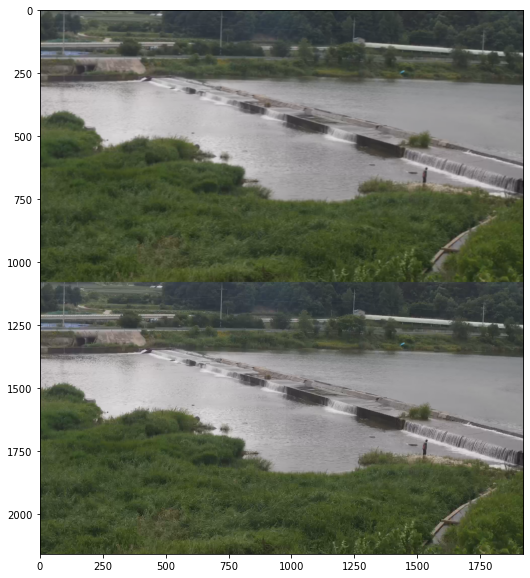

In [208]:
x0 = input_list_train[-1]
print(x0.shape)
x0_1 = gaussian_filter2d(x0, filter_shape=tuple(np.random.randint(3, 10, (2))), sigma=10)
#x0_1 = sharpness(x0, factor=10)
x0_1 = x0_1.numpy()

print(x0_1.shape)
print('diff', np.sum(np.abs(x0 - x0_1)))
x0_stack = np.concatenate((x0_1, x0), axis=0).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.imshow(x0_stack)

In [290]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    
    inputs = Input(shape=(None, None, 3))  
    nets_3 = create_resnet_backbone(inputs / 255)
    features = featurePyramidNet(nets_3)
   
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    
    conv_c0 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)  
    conv_c4 = keras.layers.Conv2D(anchor_k * num_classes, 3, 1, padding="same", kernel_initializer=kernel_init, kernel_regularizer=regulizer, bias_initializer=prior_probability)       
    drop = keras.layers.Dropout(0.2)
    
    cbox_outputs = []
    #N = 1        
    N = tf.shape(features[0])[0]# TFLite cannot convert tf.shape() function
    for feature in features:            
        cls_out = conv_c4(drop(conv_c0(feature)))
        #cls_out = conv_c4(drop(conv_c3(conv_c2(conv_c1(conv_c0(feature))))))
        #box_out = conv_b4(drop(conv_b3(conv_b2(conv_b1(conv_b0(feature))))))                
        cbox_out = tf.reshape(cls_out, [N, -1, num_classes])
        cbox_outputs.append(cbox_out)
    
    outputs = tf.concat(cbox_outputs, axis=1)    
    return keras.Model(inputs=inputs, outputs=outputs)    

In [291]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
    if False:        
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)        
        anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])
    else:
        image_h = padded_image_shape[0]#tflite
        image_w = padded_image_shape[1]
        anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
        
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:5+num_classes_real]
    cls_prob = tf.nn.softmax(cls_score)
    cls_prob_max = tf.reduce_max(cls_prob, -1)
    #cls_predictions = tf.round(objectness) * cls_predictions         
    #cls_predictions = objectness
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    #scores = tf.sqrt(scores * tf.reshape(cls_prob_max, [-1, 1]))#new
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)        
    return output   

In [293]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes

        
    def call(self, y_cls, y_pred):
        #shape=(None, None),  shape=(None, None, num_class), dtype=float32)
        #alpha:0.25        
        y_cls = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls, depth=self._num_classes, dtype=tf.float32,)
        is_exist_non_human_class = tf.reduce_any(y_cls > 1)
        y_positive = tf.cast(y_cls > 0, tf.float32)          
        objectness = y_pred[:, :, 0] + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
        pt = tf.nn.sigmoid(objectness)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f
        
        y_hot = y_hot[:, :, :num_classes_real]
        cls_pt = tf.nn.softmax(y_pred[:, :, 1:1+num_classes_real])        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_cls = tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)                
                
        if False:#new
            FP = (1 - y_positive) * tf.round(pt)
            FP_max_prob = tf.reduce_max((1 - y_positive) * pt, -1, True)
            FP_train_target =  (1 - y_positive) * tf.cast(pt > FP_max_prob - 0.01, tf.float32)
            #loss_cls = (y_positive + FP_train_target) * loss_cls
            loss_cls = (y_positive + FP) * loss_cls
        else:
            loss_cls = y_positive * loss_cls
        
        loss = self._gamma * (loss_obj + loss_cls)
        return loss


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes-1)
        self._box_loss = RetinaNetBoxLoss(delta)     
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        y_cls = y_true[:, :, 4]
        positive_max_mask = y_true[:, :, 5] > 0#new
        
        box_predictions = y_pred[:, :, :4]
        h_obj = tf.nn.sigmoid(y_pred[:, :, 4])        
        cls_predictions = y_pred[:, :, 4:-1]        
        
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions) 
                        
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        box_loss = tf.where(positive_mask, box_loss, 0.0)    
        
        max_alpha = 0.1
        clf_loss = tf.where(positive_max_mask, (1 + max_alpha) * clf_loss, (1 - max_alpha) * clf_loss)        
        box_loss = tf.where(positive_max_mask, (1 + max_alpha) * box_loss, (1 - max_alpha) * box_loss)
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = clf_loss + box_loss# + flip_loss
        return loss
 

In [294]:
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_obj_prob = tf.nn.sigmoid(y_pred[:, :, 4])
    h_cls_symbol = tf.round(h_obj_prob)    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = y_cls > 0
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    h_cls = tf.math.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls, h_cls), y_positive)    
    return acc


In [295]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [296]:
def generator():    
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]        
        yield (x, y_box)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5]))
    )
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]    
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (1080, 1920, 3) (5, 5) [2.   0.77 0.68 0.78 0.71]


In [297]:
batch_size = 3 # 5 OOM-Warn
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch_train, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)


In [298]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=False
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

img (1024, 1920, 3) <class 'numpy.ndarray'> 0 98.31078592936198 255


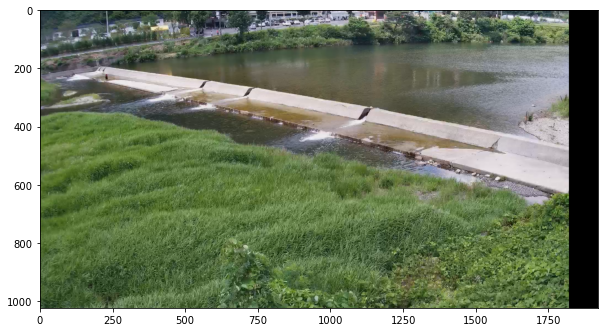

In [186]:
for image, cbbox in train_dataset: 
    img = image[0].numpy().astype(np.uint8)
    print('img', img.shape, type(img), np.min(img), np.mean(img), np.max(img))
    #print('cbbox', cbbox)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    break
    

In [161]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
for image, cbbox in train_dataset:         
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    img_m, image_height, image_width, image_ch = image.shape
    anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                           for i in range(level_start, level_end)]
    print('anchor_feature_size', anchor_feature_size)    
    m = len(cbbox)
    
    positive_count = np.sum(cls_gt>0)

    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

anchor_feature_size [(128.0, 240.0), (64.0, 120.0)]
cbbox (1, 1036800, 6)
cls_sum 1010 1035779 11 0
cls_mean 0.0009741512345679013 0.9990152391975309 1.0609567901234568e-05 1.0609567901234568e-05
shape (3, 1024, 1920, 3) (1, 1036800, 6) unique [-1.  0.  1.]
anchor_feature_size [(128.0, 240.0), (64.0, 120.0)]
cbbox_anchor (1, 128, 240, 9) 198 276280 2 0 ratio 7.2337962962962966e-06
cbbox_anchor (1, 64, 120, 9) 0 69120 0 0 ratio 0.0


Text(0.5, 1.0, '(1, 128, 240, 9)7.2337962962962966e-06 2')

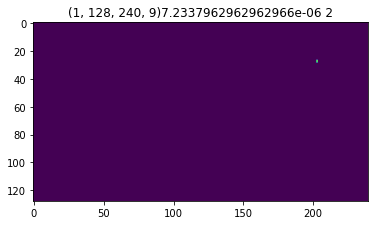

In [162]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [163]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
#pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
#pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
#pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = 0#pmap2.astype(np.uint8)
pmap3 = 0#pmap3.astype(np.uint8)
pmap4 = 0#pmap4.astype(np.uint8)

Text(0.5, 1.0, '6.510416666666667e-05')

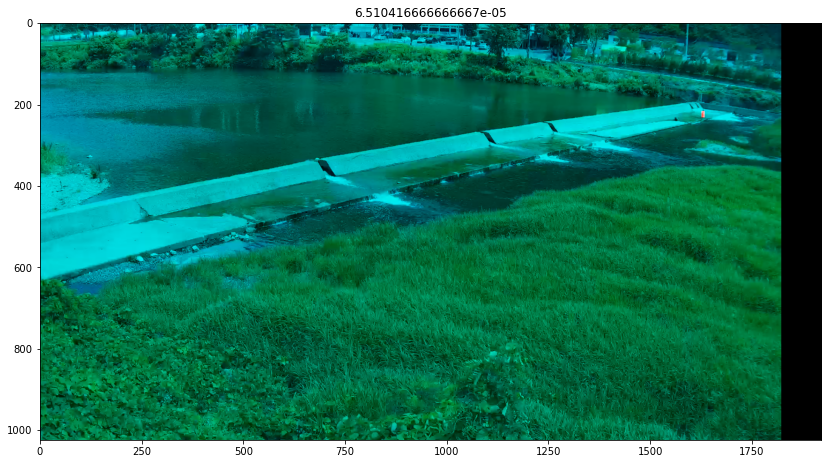

In [164]:
pmap_with_img =  np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [165]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [299]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-1, momentum=0.2, clipvalue=10.)#, clipvalue=10.
loss_fn = RetinaNetLoss(num_classes)
model = createRetinaNet(num_classes, anchor_k)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[recall, precision, accuracy])
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=200
    )
]

In [300]:
loss_list = []
loss_var_list = []
load_weight()
print(len(input_list_train), len(input_list_test))

latest_checkpoint retinanet/water
594 594


In [302]:
out = model.evaluate(val_dataset.take(1000))
# no split : recall: 0.90 - precision: 0.95 - accuracy: .91
# split    : recall: 0.90 - precision: 0.86 - accuracy: .94
# no split : recall: 0.89 - precision: 0.96 - accuracy: .94
# dense_obj: recall: 0.93 - precision: 0.92 - accuracy: .94
# res24 138ms/step - loss: 1.5627 - recall: 0.8504 - precision: 0.9359 - accuracy: 0.9412
# res24  unihead 47ms/step - loss: 1.3379 - recall: 0.9141 - precision: 0.9707 - accuracy: 0.9456

594/594 [==============================] - 28s 47ms/step - loss: 1.3379 - recall: 0.9141 - precision: 0.9707 - accuracy: 0.9456


In [301]:
epochs = 1000
hist = model.fit(
    train_dataset.take(10000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)
'''
water only      204ms/step - loss: 0.8671 - recall: 0.8588 - precision: 0.9545 - accuracy: 0.8594
                
1171/117 - 293s 251ms/step - loss: 0.6635 - recall: 0.8139 - precision: 0.9277 - accuracy: 0.9415
860/860  - 177s 205ms/step - loss: 0.4931 - recall: 0.8921 - precision: 0.9606 - accuracy: 0.9735 - flip_accuracy: 0.6377
b4 : 628ms
'''

Epoch 1/1000
198/198 [==============================] - 70s 352ms/step - loss: 0.9875 - recall: 0.9389 - precision: 0.9934 - accuracy: 0.9855
Epoch 2/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.9894 - recall: 0.9439 - precision: 0.9921 - accuracy: 0.9854
Epoch 3/1000
198/198 [==============================] - 72s 366ms/step - loss: 0.9809 - recall: 0.9428 - precision: 0.9938 - accuracy: 0.9866
Epoch 4/1000
198/198 [==============================] - 71s 361ms/step - loss: 0.9727 - recall: 0.9394 - precision: 0.9914 - accuracy: 0.9868
Epoch 5/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.9762 - recall: 0.9446 - precision: 0.9941 - accuracy: 0.9858
Epoch 6/1000
198/198 [==============================] - 70s 356ms/step - loss: 0.9830 - recall: 0.9400 - precision: 0.9936 - accuracy: 0.9826
Epoch 7/1000
198/198 [==============================] - 71s 356ms/step - loss: 0.9764 - recall: 0.9409 - precision: 0.9941 - accuracy: 0.9846
Epoch 

198/198 [==============================] - 71s 357ms/step - loss: 0.9068 - recall: 0.9476 - precision: 0.9945 - accuracy: 0.9885
Epoch 59/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8946 - recall: 0.9517 - precision: 0.9939 - accuracy: 0.9869
Epoch 60/1000
198/198 [==============================] - 71s 357ms/step - loss: 0.8994 - recall: 0.9521 - precision: 0.9940 - accuracy: 0.9897
Epoch 61/1000
198/198 [==============================] - 71s 360ms/step - loss: 0.9031 - recall: 0.9485 - precision: 0.9942 - accuracy: 0.9885
Epoch 62/1000
198/198 [==============================] - 71s 357ms/step - loss: 0.9058 - recall: 0.9516 - precision: 0.9944 - accuracy: 0.9888
Epoch 63/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8954 - recall: 0.9472 - precision: 0.9939 - accuracy: 0.9902
Epoch 64/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.9147 - recall: 0.9493 - precision: 0.9940 - accuracy: 0.9886
Epoch 65/1000

198/198 [==============================] - 71s 357ms/step - loss: 0.8488 - recall: 0.9542 - precision: 0.9942 - accuracy: 0.9920
Epoch 116/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.8672 - recall: 0.9527 - precision: 0.9942 - accuracy: 0.9896
Epoch 117/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8646 - recall: 0.9543 - precision: 0.9947 - accuracy: 0.9896
Epoch 118/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8460 - recall: 0.9572 - precision: 0.9950 - accuracy: 0.9913
Epoch 119/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8581 - recall: 0.9530 - precision: 0.9957 - accuracy: 0.9896
Epoch 120/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.8480 - recall: 0.9609 - precision: 0.9950 - accuracy: 0.9892
Epoch 121/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.8509 - recall: 0.9545 - precision: 0.9940 - accuracy: 0.9903
Epoch 1

Epoch 172/1000
198/198 [==============================] - 71s 357ms/step - loss: 0.8116 - recall: 0.9605 - precision: 0.9950 - accuracy: 0.9914
Epoch 173/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8274 - recall: 0.9588 - precision: 0.9955 - accuracy: 0.9913
Epoch 174/1000
198/198 [==============================] - 71s 357ms/step - loss: 0.8135 - recall: 0.9608 - precision: 0.9938 - accuracy: 0.9914
Epoch 175/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.8134 - recall: 0.9632 - precision: 0.9948 - accuracy: 0.9920
Epoch 176/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.8247 - recall: 0.9589 - precision: 0.9952 - accuracy: 0.9907
Epoch 177/1000
198/198 [==============================] - 70s 356ms/step - loss: 0.8191 - recall: 0.9591 - precision: 0.9951 - accuracy: 0.9909
Epoch 178/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.8173 - recall: 0.9612 - precision: 0.9951 - accuracy:

198/198 [==============================] - 71s 357ms/step - loss: 0.7942 - recall: 0.9630 - precision: 0.9952 - accuracy: 0.9899
Epoch 229/1000
198/198 [==============================] - 70s 355ms/step - loss: 0.7947 - recall: 0.9655 - precision: 0.9952 - accuracy: 0.9909
Epoch 230/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7867 - recall: 0.9610 - precision: 0.9946 - accuracy: 0.9908
Epoch 231/1000
198/198 [==============================] - 71s 360ms/step - loss: 0.7896 - recall: 0.9636 - precision: 0.9947 - accuracy: 0.9922
Epoch 232/1000
198/198 [==============================] - 71s 357ms/step - loss: 0.7912 - recall: 0.9634 - precision: 0.9953 - accuracy: 0.9915
Epoch 233/1000
198/198 [==============================] - 71s 360ms/step - loss: 0.7985 - recall: 0.9637 - precision: 0.9951 - accuracy: 0.9907
Epoch 234/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.7926 - recall: 0.9633 - precision: 0.9955 - accuracy: 0.9901
Epoch 2

Epoch 285/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7536 - recall: 0.9664 - precision: 0.9952 - accuracy: 0.9915
Epoch 286/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7567 - recall: 0.9669 - precision: 0.9959 - accuracy: 0.9927
Epoch 287/1000
198/198 [==============================] - 71s 361ms/step - loss: 0.7672 - recall: 0.9685 - precision: 0.9956 - accuracy: 0.9913
Epoch 288/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7613 - recall: 0.9685 - precision: 0.9951 - accuracy: 0.9921
Epoch 289/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.7616 - recall: 0.9680 - precision: 0.9951 - accuracy: 0.9922
Epoch 290/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7573 - recall: 0.9673 - precision: 0.9949 - accuracy: 0.9924
Epoch 291/1000
198/198 [==============================] - 71s 360ms/step - loss: 0.7686 - recall: 0.9679 - precision: 0.9956 - accuracy:

198/198 [==============================] - 71s 358ms/step - loss: 0.7367 - recall: 0.9681 - precision: 0.9961 - accuracy: 0.9936
Epoch 342/1000
198/198 [==============================] - 71s 360ms/step - loss: 0.7336 - recall: 0.9684 - precision: 0.9961 - accuracy: 0.9943
Epoch 343/1000
198/198 [==============================] - 71s 357ms/step - loss: 0.7395 - recall: 0.9679 - precision: 0.9956 - accuracy: 0.9918
Epoch 344/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7455 - recall: 0.9702 - precision: 0.9960 - accuracy: 0.9919
Epoch 345/1000
198/198 [==============================] - 71s 358ms/step - loss: 0.7419 - recall: 0.9705 - precision: 0.9962 - accuracy: 0.9922
Epoch 346/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.7461 - recall: 0.9666 - precision: 0.9962 - accuracy: 0.9918
Epoch 347/1000
198/198 [==============================] - 71s 359ms/step - loss: 0.7471 - recall: 0.9695 - precision: 0.9962 - accuracy: 0.9928
Epoch 3

KeyboardInterrupt: 

In [284]:
model.save_weights(path_weight)

In [309]:
image = tf.keras.Input(shape=[padded_image_shape[0], padded_image_shape[1], 3], name="image")
predictions = model(image, training=False)
detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.1)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [310]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(16, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=1
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 200:
            score_txt = str.format('(%d)%.2f' %(cls, score))
            ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [311]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, 1:] * scale
               
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            
            detected_box = inference_model.predict(input_image)        
            print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)
            
            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        i+=1

In [ ]:
check_test(dataset, bbox_list_train, step=300)

In [ ]:
check_test(dataset_test, bbox_list_test, step=20)

In [ ]:
#for image in input_list_test: 
for image in attach_obj_img: 
    #print('image', image.shape, image.dtype)#image (1024, 1920, 3) uint8
    #image = image[:32*32]
    input_image = tf.expand_dims(image, axis=0)
    detected_box = inference_model.predict(input_image)        
    print(input_image.shape, 'detected_box', detected_box.shape)
    #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
    cls_h = detected_box[:, 0].astype(np.int)
    scores = detected_box[:, 1]
    box = detected_box[:, 2:]# / ratio
 
    visualize_detections(
        image,
        box,
        cls_h,
        scores)
    #break

## load model from .pb file

In [ ]:
saved_model_pb = './water_pb'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:

custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
## load model from .pb filefor image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

## tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_details, output_details

In [ ]:
input_data = input_list_train[-1]
input_data = (np.expand_dims(input_data, 0)/255).astype(np.float32)
input_data = input_data[:, :padded_image_shape[0], :padded_image_shape[1]]
input_data.shape, np.max(input_data)


In [ ]:
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('input_data', input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape
detected_box = tflite_results

In [ ]:
cls_h = detected_box[:, 0].astype(np.int)
scores = detected_box[:, 1]
box = detected_box[:, 2:]
print(scores[scores > 0.5])
#print('box', box)

object_box = detected_box[scores > 0.5]

In [ ]:
object_box

In [ ]:
cls_h = object_box[:, 0].astype(np.int)
scores = object_box[:, 1]
box = object_box[:, 2:]

visualize_detections(
    input_data[0]*255,
    box,
    cls_h,
    scores,
)